In [43]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import xarray as xr
from scipy.stats import norm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sg # Operations on shapes (points, lines and polygons)
from pyproj import CRS # Coordinate Reference System (map projections)
import geopandas as gpd # Geospatial extension of Pandas
import cartopy.crs as ccrs
 
import OND

from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [3]:
FIG = "/fs/homeu1/eccc/mrd/armp/dbr000/projects/OND/figures"

### Spatio-temporal window selection

In [4]:
# This is the gridded part
lon_min = -117.5
lon_max = -112.5
lat_min = 51.5
lat_max = 56.5

# Resolution
delta = 0.1

# This is the months and years used for both the gridded and station data
#months = [1,2,3]
month = 4
year_start = 2000
year_end = 2020

In [5]:
# Map projection
ll_crs = CRS.from_proj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
ll_crs

<Geographic 2D CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs + ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Functions

In [6]:
def get_gdf(df, y='Latitude', x='Longitude', crs=ll_crs):
    df['geometry'] = [sg.Point(x,y) for (x,y) in df[[x, y]].values] # Iterate over coordinates, construct Shapely Point
    gdf = gpd.GeoDataFrame(df) # Make Pandas DataFrame a GeoPandas GeoDataFrame
    gdf.crs = crs # Initialize coordinate reference system (crs)
    return gdf

### Prepare surface station data

In [7]:
# Data downloaded on Zenodo..
path = "/home/dbr000/sitestore3/DATA/Stations/SCDNA"
scdna_file = os.path.join(path, "SCDNA_stations.csv")

### Show station and domain

In [8]:
PATH = '/home/dbr000/sitestore3/DATA'
shapefile_path = os.path.join(PATH, 'NaturalEarth', f"Cultural", f"Countries", 
                         f"ne_10m_admin_0_countries.shp")
countries = gpd.read_file(shapefile_path)
canada_sg = countries.loc[countries['ADMIN']=='Canada']['geometry'].values[0]
usa_sg = countries.loc[countries['ADMIN']=='United States of America']['geometry'].values[0]

In [9]:
shapefile_path = os.path.join(PATH, 'NaturalEarth', 'Cultural', 'States_Provinces', 
                             f"ne_10m_admin_1_states_provinces.shp")
provinces = gpd.read_file(shapefile_path)
alberta = provinces.loc[provinces['name']=='Alberta']['geometry'].values[0]

In [10]:
bbox = sg.Polygon([[lon_min,lat_min],
                   [lon_max,lat_min],
                   [lon_max,lat_max],
                   [lon_min,lat_max]])
bbox_gpd = gpd.GeoDataFrame(data={'geometry':[bbox]})

In [11]:
station_table = pd.read_csv(scdna_file, index_col=0)

In [12]:
station_table = get_gdf(station_table)

In [13]:
np.unique(station_table['Source'])

array(['EC', 'GH', 'GS', 'MR'], dtype=object)

In [14]:
ae_crs = CRS.from_proj4('+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=-99.5 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

In [15]:
countries_ae = countries.to_crs(ae_crs)
provinces_ae = provinces.to_crs(ae_crs)
station_table_ae = station_table.to_crs(ae_crs)

In [34]:
def plot_stations(axin, countries, provinces, bbox, station_table, legend_on=False):
    countries.plot(ax=axin, color='lightgrey')
    station_table.loc[station_table['Source']=='EC'].plot(ax=axin, marker='.', zorder=9, alpha=0.8, color='g', label='ECCC')
    station_table.loc[station_table['Source']=='GH'].plot(ax=axin, marker='+', zorder=8, alpha=0.8, color='b', label='GHCN')
    station_table.loc[station_table['Source']=='GS'].plot(ax=axin, marker='o', zorder=7, alpha=0.8, color='r', label='GCOS')
    #station_table.loc[station_table['Source']=='ME'].plot(ax=axin, marker='.', zorder=9, alpha=0.5, color='r')
    station_table.loc[station_table['Source']=='MR'].plot(ax=axin, marker='o', zorder=6, alpha=0.8, color='orange', label='Multiple')
    if legend_on:
        handles, labels = axin.get_legend_handles_labels()
        axin.legend(handles[3:], labels[3:], loc='lower left', fancybox=True, fontsize=18)
    countries.boundary.plot(ax=axin, color='k')
    provinces.boundary.plot(ax=axin, color='k', linestyle=':', zorder=20, alpha=0.5)
    #bbox.boundary.plot(ax=axin, zorder=10, linestyle='-', color='k') 
    return axin

In [44]:
import cartopy.mpl.ticker as cticker

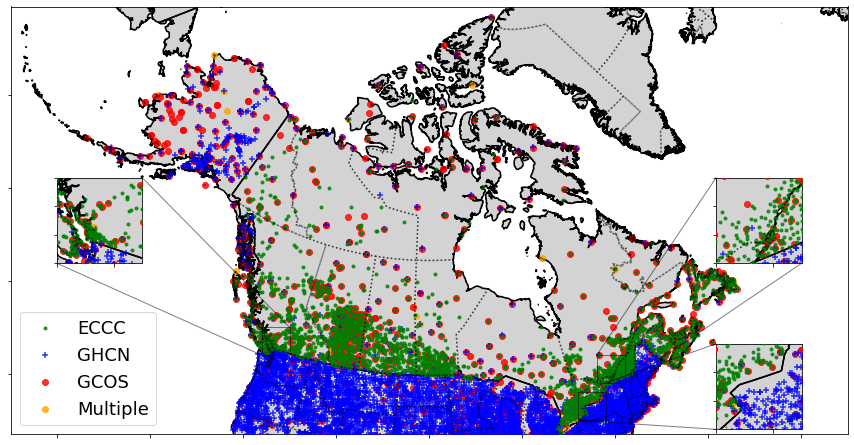

In [47]:
fig = plt.figure(figsize=(15,15))
axin = plt.gca()
axin.axis([-4500000,4500000,350000,4950000])

ax1 = inset_axes(axin, "20%", "20%", loc="center left")
ax1.axis([-1800000,-1500000,1200000,1500000])
plot_stations(ax1, countries_ae, provinces_ae, bbox_gpd, station_table_ae)
ax1.tick_params(labelleft=False, labelbottom=False)
axin.indicate_inset_zoom(ax1, edgecolor="black", zorder=100, label='Vancouver')

ax2 = inset_axes(axin, "20%", "20%", loc="lower right")
ax2.axis([1600000,1900000,500000,800000])
plot_stations(ax2, countries_ae, provinces_ae, bbox_gpd, station_table_ae)
ax2.tick_params(labelleft=False, labelbottom=False)
axin.indicate_inset_zoom(ax2, edgecolor="black", zorder=100, label='Toronto')

ax3 = inset_axes(axin, "20%", "20%", loc="center right")
ax3.axis([1800000,2100000,900000,1200000])
plot_stations(ax3, countries_ae, provinces_ae, bbox_gpd, station_table_ae)
ax3.tick_params(labelleft=False, labelbottom=False)
axin.indicate_inset_zoom(ax3, edgecolor="black", zorder=100, label='Montreal')

plot_stations(axin, countries_ae, provinces_ae, bbox_gpd, station_table_ae, legend_on=True)
#add_gridlines(axin)
axin.tick_params(labelleft=False, labelbottom=False)
plt.show()

/fs/homeu1/eccc/mrd/ords/armp/dbr000/anaconda3/envs/OND/lib/python3.7/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/fs/homeu1/eccc/mrd/ords/armp/dbr000/anaconda3/envs/OND/lib/python3.7/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


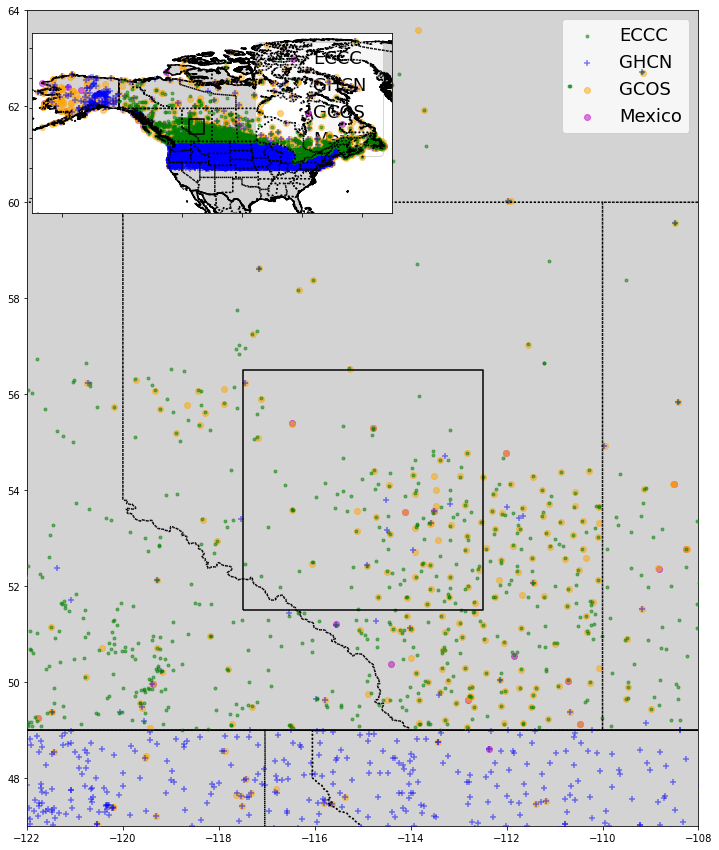

In [69]:
if True:
    fig = plt.figure(figsize=(15,15))
    axin = plt.gca()

    # Create inset
    ax = inset_axes(axin, height=3, width=5, loc=2)

    ax.axis([-170,-50,25,85])
    plot_stations(ax, countries, provinces, bbox_gpd, station_table)


    axin.axis([-122,-108,47,64])
    plot_stations(axin, countries, provinces, bbox_gpd, station_table)

    # Turn ticklabels of insets off
    ax.tick_params(labelleft=False, labelbottom=False)

    plt.show()